# Classification problem on the Twenty News Groups dataset

In this exercise, we'll use a [neural language model](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) to represent the emails in the <i>twenty newsgroups</i> dataset and build a classifier to identify emails belonging to <i>computer related topics</i> and those which aren't.

We'll use the [Paragraph Vector](https://cs.stanford.edu/~quocle/paragraph_vector.pdf) representation as described by Quoc Le et. al to encode the news groups emails as dense vectors and build our classifiers on these dense vectors.

More information on the <i>Twenty Newsgroups</i> dataset can be found on the [UCI website](http://kdd.ics.uci.edu/databases/20newsgroups/20newsgroups.html)

## Setup database connectivity

We'll reuse our module from the previous notebook (***`00_database_connectivity_setup.ipynb`***) to establish connectivity to the database

In [21]:
%run '00_database_connectivity_setup.ipynb'
%matplotlib inline
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

Your connection object is ***`conn`***:
1. Queries: You can run your queries using ***```psql.read_sql("""<YOUR SQL>""", conn)```***.
2. Create/Delete/Updates: You can run these statements using ***```psql.execute("""<YOUR SQL>""", conn)```***, followed by a ***```conn.commit()```*** command to ensure your transaction is committed. Otherwise your changes will be rolledback if you terminate your kernel.

If you created a new connection object (say to connect to a new cluster) as shown in the last section of `00_database_connectivity_setup.ipynb` notebook, use that connection object where needed.

## 1. Create your schema

In [ ]:
sql = """
    create schema YOUR_SCHEMA;
"""
psql.execute(sql, conn)
conn.commit()

## 2. Load the Twenty News Groups dataset into a database table

In [12]:
%%execsql
-- Define external table to fetch data from HDFS
drop external table if exists YOUR_SCHEMA.twenty_news_groups_ext cascade;
create external table YOUR_SCHEMA.twenty_news_groups_ext
(
    doc_id int,
    contents text,
    label text
) location ('pxf://hdm1.gphd.local:50070/user/vatsan/dstraining/twenty_news_groups_processed.tsv?profile=hdfstextsimple') 
format 'CSV' (DELIMITER = E'\t');

-- create an internal table
drop table if exists YOUR_SCHEMA.twenty_news_groups cascade;
create table YOUR_SCHEMA.twenty_news_groups
as
(
    select 
        *
    from
        YOUR_SCHEMA.twenty_news_groups_ext
) distributed randomly;

In [41]:
%%showsql
select
    *
from
    YOUR_SCHEMA.twenty_news_groups
limit 10;

,doc_id,contents,label
0,58,"From: acooper@mac.cc.macalstr.edu (Turin Turambar, ME Department of Utter Misery)\nSubject: Re: Societally acceptable behavior\nOrganization: Macalester College\nLines: 55\n\nIn article <C5sA29.14s@news.cso.uiuc.edu>, cobb@alexia.lis.uiuc.edu (Mike Cobb) writes:\n> I guess I'm delving into a religious language area. What exactly is morality \n> or morals? \n\nI hope there is not one- with a subject like this you just have a spiral. What\nwould then be a morality of a morality of morals. Labels don't make arguments. \nOne really needs a solid measuring stick by which most actions can be\ninterpreted, even though this would hardly seem moral. For example ""The best\nthing for me is to ensure that I will eat and drink enough. Hence all actions\nmust be weighed against this one statement."" whatever helps this goal is\n""moral"", whatever does not is ""immoral""\n\nOf course this leads such a blank space: there are so many different ways to\nfulfill a goal, one would need a ""hyper-morality"" to apply to just the methods.\n\n>I never thought of eating meat to be moral or immoral, but I think\n> it could be. How do we differentiate between not doing something because it is\n> a personal choice or preference and not doing something because we see it as \n> immoral? Do we fall to what the basis of these morals are?\n\nSeems to me we only consider something moral or immoral if we stop to think\nabout it long enough :) On the other hand, maybe it is our first gut\nreaction... Which? Who knows: perhaps here we have a way to discriminate\nmorals. I don't instinctively thing vegetarianism is right (the same way I\ninstinctively feel torture is wrong), but if I thought about it long enough and\nlistened to the arguments, I could perhaps reason that it was wrong (is that\npossible!? :) ) See the difference?\n\n> \n> Also, consensus positions fall to a might makes right. Or, as you brought out,\n> if whatever is right is what is societally mandated then whoever is in control\n> at the time makes what is right\n> \n> MC\n> MAC\n> --\n> ****************************************************************\n> Michael A. Cobb\n> ""...and I won't raise taxes on the middle University of Illinois\n> class to pay for my programs."" Champaign-Urbana\n> -Bill Clinton 3rd Debate cobb@alexia.lis.uiuc.edu\n> \n> Nobody can explain everything to anybody. G.K.Chesterton\n-- \n\n\nbest regards,\n\n--Adam\n\n********************************************************************************\n* Adam John Cooper\t\t""Verily, often have I laughed at the weaklings *\n* (612) 696-7521\t\t who thought themselves good simply because *\n* acooper@macalstr.edu\t\t\t\tthey had no claws.""\t *\n********************************************************************************\n",alt.atheism
1,154,"From: frank@D012S658.uucp (Frank O'Dwyer)\nSubject: Re: Societal basis for morality\nOrganization: Siemens-Nixdorf AG\nLines: 49\nNNTP-Posting-Host: d012s658.ap.mchp.sni.de\n\nIn article <1993Apr20.004119.6119@cnsvax.uwec.edu> nyeda@cnsvax.uwec.edu (David Nye) writes:\n\nYou asked me to look over here, but I was on my way back anyway :-)\n\n#[reply to cobb@alexia.lis.uiuc.edu (Mike Cobb)]\n# \n#>If morals come from what is societally accepted, why follow that? What\n#>right do we have to expect others to follow our notion of societally\n#>mandated morality? Pardon the extremism, but couldn't I murder your\n#>""brother"" and say that I was exercising my rights as I saw them, was\n#>doing what felt good, didn't want anyone forcing their morality on me,\n#>or I don't follow your ""morality"" ?\n# \n#I believe that morality is subjective. Each person is entitled to his\n#own moral attitudes. Mine are not a priori more correct than someone\n#elses. This does not mean however that I must judge another on the\n#basis of his rather than my moral standards. While he is entitled to\n#believe what his own moral sense tells him, the rest of society is\n#entitled to pas

## 3. Create document vectors using Paragraph Vectors by Quoc Le, Mikolov et. al (local version) 

In [118]:
sql = """
    select 
        * 
    from 
        YOUR_SCHEMA.twenty_news_groups 
        limit 100
"""
df = psql.read_sql(sql, conn)
conn.commit()
df.head()

,doc_id,contents,label
0,173,"From: csfed@uxa.ecn.bgu.edu (Frank Doss)\nSubject: Re: Science and theories\nOrganization: Educational Computing Network\nLines: 27\nNNTP-Posting-Host: uxa.ecn.bgu.edu\n\nIn article <C5u7Bq.J43@news.cso.uiuc.edu> cobb@alexia.lis.uiuc.edu (Mike Cobb) writes:\n\n>The examples he gave were quarks and continental plates. Are there \n\nSounds like more of the same. Gods were used to describe almost\neverything in the past. As we come to understand the underpinnings of\nmore and more, the less we credit to a god. Now, the not-so-well\nunderstood elements (at least by the author) includes quarks and tectonic\ndrift. I guess that's better than describing the perceived patterns of\nstars in the sky as heroes being immortalized by the gods.\n\nKinda sounds like old-earth creation--It seems that life did, indeed, evolve\nfrom a common ancestor. What caused that initial common ancestor?\n\nAre we going to hear another debate on causeless events? ;-)\n\n>explanations of science or parts of theories that are not measurable in and of\n>themselves, or can everything be quantified, measured, tested, etc.? \n>\n>MAC\n> Michael A. Cobb\n\n-- \nFrank Doss \nThe above stated words are my opinions and do not reflect the opinions,\nattitudes, or policies of my employer or any affilliated organizations.\n\n",alt.atheism
1,78,"From: livesey@solntze.wpd.sgi.com (Jon Livesey)\nSubject: Re: A Little Too Satanic\nOrganization: sgi\nLines: 56\nDistribution: world\nNNTP-Posting-Host: solntze.wpd.sgi.com\n\nIn article <66615@mimsy.umd.edu>, mangoe@cs.umd.edu (Charley Wingate) writes:\n|> Jon Livesey writes:\n|> \n|> |> What I said was that people took time to *copy* *the* *text* correctly.\n|> |> Translations present completely different issues.\n|>\n|> \n|> >So why do I read in the papers that the Qumram texts had ""different\n|> >versions"" of some OT texts. Did I misunderstand?\n|> \n|> Reading newspapers to learn about this kind of stuff is not the best idea in\n|> the world. Newspaper reporters are notoriously ignorant on the subject of\n|> religion, and are prone to exaggeration in the interests of having a ""real""\n|> story (that is, a bigger headline).\n|> \n|> Let's back up to 1935. At this point, we have the Masoretic text, the\n|> various targums (translations/commentaries in aramaic, etc.), and the\n|> Septuagint, the ancient greek translation. The Masoretic text is the\n|> standard Jewish text and essentially does not vary. In some places it has\n|> obvious corruptions, all of which are copied faithfully from copy to copy.\n|> These passages in the past were interpreted by reference to the targums and\n|> to the Septuagint.\n\nSo when they took the time to *copy* *the* *text* correctly, that includes\n""obvious corruptions?""\n\n|> \n|> Now, the septuagint differs from the masoretic text in two particulars:\n|> first, it includes additional texts, and second, in some passages there are\n|> variant readings from the masoretic text (in addition to ""fixing""/predating\n|> the various corrupted passages). It must be emphasized that, to the best of\n|> my knowledge, these variations are only signifcant to bible scholars, and\n|> have little theological import.\n\nSo when they took the time to *copy* *the* *text* correctly, that does not\nexclude ""variant readings from the masoretic text"" which are ""of little \ntheological import""\n\n|> \n|> The dead sea scroll materials add to this an ancient *copy* of almost all of\n|> Isaiah and fragments of various sizes of almost all other OT books. There\n|> is also an abundance of other material, but as far as I know, there is no\n|> sign there of any hebrew antecdent to the apocrypha (the extra texts in the\n|> septuagint). As far as analysis has proceeded, there are also variations\n|> between the DSS texts and the masoretic versions. These tend to reflect the\n|> septuagint, where the latter isn't obviously in error. Again, though, the\n|> differences (thus far) are not si

In [119]:
def get_paragraph_vectors(df):
    """
        Train paragraph vectors
    """
    from gensim.models.doc2vec import TaggedDocument
    from gensim.models import Doc2Vec
    import pandas as pd    
    #words=tokenize_document(d), tags=label) 
    docs = [
            TaggedDocument(words=d.split(), tags=[label]) 
                for d, label in zip(df['contents'], df['doc_id'])
           ]            
    doc_ids = df['doc_id']
    #Train doc2vec model in Gensim
    model = Doc2Vec(
                documents=docs, 
                min_count=1, 
                window=10, 
                size=10, 
                sample=1e-4, 
                negative=5, 
                workers=10
            )
    return model, docs

In [120]:
model, docs = get_paragraph_vectors(df)

In [121]:
print '#num_documents',len(model.docvecs)
print '#doc_vec_size',model.docvecs[0].shape
print 'sample doc',docs[0]
print 'doc_vec of sample doc',model.docvecs[0]

#num_documents 1491
#doc_vec_size (10,)
sample doc TaggedDocument(['From:', 'csfed@uxa.ecn.bgu.edu', '(Frank', 'Doss)', 'Subject:', 'Re:', 'Science', 'and', 'theories', 'Organization:', 'Educational', 'Computing', 'Network', 'Lines:', '27', 'NNTP-Posting-Host:', 'uxa.ecn.bgu.edu', 'In', 'article', '<C5u7Bq.J43@news.cso.uiuc.edu>', 'cobb@alexia.lis.uiuc.edu', '(Mike', 'Cobb)', 'writes:', '>The', 'examples', 'he', 'gave', 'were', 'quarks', 'and', 'continental', 'plates.', 'Are', 'there', 'Sounds', 'like', 'more', 'of', 'the', 'same.', 'Gods', 'were', 'used', 'to', 'describe', 'almost', 'everything', 'in', 'the', 'past.', 'As', 'we', 'come', 'to', 'understand', 'the', 'underpinnings', 'of', 'more', 'and', 'more,', 'the', 'less', 'we', 'credit', 'to', 'a', 'god.', 'Now,', 'the', 'not-so-well', 'understood', 'elements', '(at', 'least', 'by', 'the', 'author)', 'includes', 'quarks', 'and', 'tectonic', 'drift.', 'I', 'guess', "that's", 'better', 'than', 'describing', 'the', 'perceived', 'patte

#### Obtain doc2vec representation of a new document

In [122]:
model.infer_vector(['hello', 'world', 'bye', 'world'])

array([ 0.00239663, -0.01788618,  0.05665193, -0.0151288 , -0.00252076,
        0.03537806,  0.03646427,  0.01192429,  0.02087626,  0.0387573 ], dtype=float32)

## 4. Define PL/Python UDF to train doc2vec models

In [136]:
%%execsql
--1) SFUNC: State transition function, part of a User-Defined-Aggregate definition
-- This function will merely stack every row of input, into the GD variable
drop function if exists YOUR_SCHEMA.stack_rows(
    text,
    text[],
    text,
    text,
    text
) cascade;
create or replace function YOUR_SCHEMA.stack_rows(
    key text,
    header text[], -- name of the features column and the dependent variable column
    doc_id text, -- id field for each document
    content text, -- content of the document
    label text -- dependent variable column
)
returns text
as
$$
    if 'header' not in GD:
        GD['header'] = header
    if not key:
        gd_key = 'stack_rows'
        GD[gd_key] = [[doc_id, content, label]]
        return gd_key
    else:
        GD[key].append([doc_id, content, label])
        return key
$$language plpythonu;

--2) Define the User-Defined Aggregate (UDA) consisting of a state-transition function (SFUNC), 
-- a state variable and a FINALFUNC (optional)
drop aggregate if exists YOUR_SCHEMA.stack_rows( 
    text[], -- header (feature names)
    text, -- doc_id
    text, -- document content,
    text -- label
) cascade;
create ordered aggregate YOUR_SCHEMA.stack_rows(
    text[], -- header (feature names)
    text, -- doc_id
    text, -- document content,
    text -- label
)
(
    SFUNC = YOUR_SCHEMA.stack_rows,
    STYPE = text -- the key in GD used to hold the data across calls
);

--3) UDT to hold document vectors
drop type if exists YOUR_SCHEMA.doc_vectors cascade;
create type YOUR_SCHEMA.doc_vectors
as
(
    doc_id text,
    doc_vec float8[],
    label text
);

--4) UDF for training doc2vec model in Gensim
drop function if exists YOUR_SCHEMA.train_doc2vec(
    text,
    int,
    int,
    int
);
create or replace function YOUR_SCHEMA.train_doc2vec(
    key text,
    vect_size int,
    window_size int,
    num_workers int
)
returns setof YOUR_SCHEMA.doc_vectors
as
$$
    from unicodedata import category as uc_cat
    from nltk.tokenize import word_tokenize, sent_tokenize
    from nltk.stem import WordNetLemmatizer
    from nltk.corpus import stopwords
    import string, re
    from gensim.models.doc2vec import TaggedDocument
    from gensim.models import Doc2Vec
    import pandas as pd    
    
    def tokenize_document(doc):
        """
            Use NLTK to tokenize document
        """        
        #discard stopwords
        stop_en = stopwords.words('english')
        
        #Use a wordnet lemmatizer to stem the tokens
        wnl = WordNetLemmatizer()
        
        #tokenize the documents using NLTK
        tokens = [w.strip().decode('utf8') for sent in sent_tokenize(doc) for w in word_tokenize(sent)] if doc else None
        
        if(not tokens):
            return [(0, None),]

        #Remove control characters
        tokens = map(lambda x: ''.join(c for c in x if uc_cat(c) != 'Cc'), tokens)
        
        #Remove punctuations if they are tokens by themselves
        tokens = filter(lambda x: x not in set(list(string.punctuation.decode('utf-8'))), tokens)
        
        #Replace phone numbers with <PHONE>
        phone_pat = re.compile(r'''
                        # don't match beginning of string, number can start anywhere
            (\d{1,2}-?)?
            (\d{3})     # area code is 3 digits (e.g. '800')
            \D*         # optional separator is any number of non-digits
            (\d{3})     # trunk is 3 digits (e.g. '555')
            \D*         # optional separator
            (\d{4})     # rest of number is 4 digits (e.g. '1212')
            \D*         # optional separator
            (\d*)       # extension is optional and can be any number of digits
            $           # end of string
            ''', re.VERBOSE)
        tokens = map(lambda x: u'<PHONE>' if phone_pat.match(x) else x, tokens)
        
        #Replace numbers with <NUM>
        num_pat = re.compile(r'^(-|\+)?(\d*).?(\d+)')
        tokens = map(lambda x: u'<NUM>' if num_pat.match(x) else x, tokens)
        
        #Replace dates
        date_pat =  re.compile(r'^(\d{1,2})(/|-)(\d{1,2})(/|-)(\d{2,4})$')
        tokens = map(lambda x: u'<DATE>' if date_pat.match(x) else x, tokens)
        
        #Remove tokens which are solely composed on non-alpha characters
        non_alpha = re.compile(r'''^(\W+)$''', re.VERBOSE)
        tokens = filter(lambda x: not non_alpha.match(x), tokens)
        
        #Strip out any lingering punctuations now that the document has been tokenized by NLTK
        tokens = map(lambda x: ''.join(c for c in x if not uc_cat(c).startswith('P')), tokens)
        
        #use the wordnet lemmatizer
        lemmatized_tokens = map(lambda x: wnl.lemmatize(x), tokens)
        
        #filter out empty tokens and stopwords
        lemmatized_tokens = filter(lambda x: x and x.strip() and x.strip() not in stop_en, lemmatized_tokens)
        return lemmatized_tokens
    
    def train_doc2vec():
        """
            Train doc2vec models in gensim
        """
        if key in GD:
            header = GD['header']
            plpy.info('Header:',header)
            df = pd.DataFrame(GD[key], columns=header)
            plpy.info('Dataframe shape:',df.shape)
            docs = [
                    TaggedDocument(words=tokenize_document(d), tags=[tag]) 
                        for d, tag in zip(df[header[1]], df[header[0]])
                   ]            
            doc_ids = df[header[0]]
            labels = df[header[2]]
            plpy.info('Training doc2vec')
            #Train doc2vec model in Gensim
            model = Doc2Vec(
                        documents=docs, 
                        min_count=1, 
                        window=window_size, 
                        size=vect_size, 
                        sample=1e-4, 
                        negative=5, 
                        workers=num_workers
                    )
            return zip(doc_ids, model.docvecs, labels)
    #Invoke doc2vec
    return train_doc2vec()
$$ language plpythonu;

In [108]:
%%execsql
drop table if exists YOUR_SCHEMA.twenty_news_groups_doc2vec_representation cascade;
create table YOUR_SCHEMA.twenty_news_groups_doc2vec_representation
as
(
    select
        (doc_vecs).*
    from
    (
        select
            YOUR_SCHEMA.train_doc2vec(
                stacked_input_key,
                20, -- size of the output vector
                10, -- window_size
                10 -- num_workers (threads)
            ) as doc_vecs
        from
        (
            select
                YOUR_SCHEMA.stack_rows(
                    ARRAY['doc_id', 'contents', 'label'], --header or names of input fields
                    doc_id,
                    contents,
                    label
                ) as stacked_input_key
            from
                YOUR_SCHEMA.twenty_news_groups
        )q1
    )q2
) distributed by (doc_id);

In [143]:
%%showsql
select
    *
from
    YOUR_SCHEMA.twenty_news_groups_doc2vec_representation
limit 10;

,doc_id,doc_vec,label
0,421,"[-0.0162567, 0.00640558, -0.0319764, -0.0274248, -0.0372388, 0.0265061, -0.0343747, 0.0145012, -0.00209146, -0.0405663, 0.0343613, -0.0422859, -0.00206888, -0.0618418, 0.0100281, 0.00957236, 0.00245993, -0.0346243, -0.0275735, -0.00153059]",comp.graphics
1,142,"[0.0287947, -0.0838569, -0.0781008, -0.0830135, -0.0775834, 0.0868943, -0.00836284, -0.00884065, 0.0409157, -0.0411672, -0.0979297, -0.0279642, -0.00306713, -0.00927339, -0.0885007, 0.0831769, 0.0211072, -0.00763965, -0.0741872, -0.00316988]",alt.atheism
2,1972,"[0.0348526, -0.106675, -0.038423, -0.0955747, -0.0516444, 0.000549732, -0.162949, 0.0992188, 0.073194, -0.0691682, 0.120136, 0.00964684, -0.0750248, -0.0547911, 0.0520042, 0.134517, 0.129015, -0.0296789, 0.0156653, -0.0923599]",comp.windows.x
3,1998,"[-0.0464875, 0.0649271, -0.203933, -0.327844, -0.180713, 0.216827, -0.21077, 0.122838, 0.0473668, -0.033562, 0.186332, 0.0773628, 0.0975556, -0.387927, 0.130198, 0.291937, 0.147604, 0.0510774, 0.100246, -0.141307]",comp.windows.x
4,490,"[-0.041306, -0.0276567, -0.150082, -0.0194698, -0.0728029, -0.00425778, -0.0793157, 0.079874, 0.01403, -0.0435103, 0.0535301, -0.0623375, 0.00359212, -0.0864903, 0.0760027, -0.000643778, 0.0876219, 0.0501357, 0.0486506, 0.0460701]",comp.graphics
5,348,"[0.00667879, -0.0491869, -0.0728234, -0.00277791, -0.0360861, 0.00700159, 0.0136226, 0.0410659, -0.00317544, -0.0239412, 0.022206, -0.008782, -0.00983796, -0.0160417, 0.0463907, 0.0865696, 0.0639555, 0.0126365, 0.0989312, 0.0249212]",comp.graphics
6,56,"[0.150542, -0.159149, -0.306852, -0.125841, -0.144607, 0.137373, 0.009954, 0.02002, 0.16023, -0.0807755, -0.160564, -0.0232937, 0.104897, -0.0310717, -0.223183, 0.225264, 0.114698, 0.035119, -0.188344, -0.0676671]",alt.atheism
7,1316,"[-0.0218237, -0.012275, -0.0668791, -0.0726829, -0.0889829, 0.0117783, -0.0310245, 0.0170602, 0.0407811, -0.0360363, 0.0462637, -0.0680719, -0.013038, -0.0113836, -0.0470533, 0.124959, 0.123977, -0.0828689, 0.0246666, 0.011108]",comp.sys.ibm.pc.hardware
8,1381,"[-0.0254411, -0.0150829, -0.0534905, -0.0795205, -0.119269, -0.0371484, -0.0697154, 0.0776581, 0.145638, -0.0364588, 0.0337367, -0.00233214, -0.0182445, -0.000567661, -0.0398344, 0.0782709, 0.114415, -0.099335, 0.0186272, -0.111456]",comp.sys.ibm.pc.hardware
9,1778,"[0.076093, -0.0202146, -0.17295, -0.144834, -0.12579, 0.042422, -0.0506727, 0.00326078, 0.0153817, -0.0408021, 0.10379, 0.0716964, 0.0486067, -0.0081311, -0.0505118, 0.196557, 0.167028, -0.106257, 0.0680318, -0.0123852]",comp.sys.mac.hardware


## 5. Create train & test split

In [144]:
%%execsql
-- Set the seed to ensure the random splits are repeatable
-- This is important if you want to measure performance 
-- of classifiers based by varying the "num_bits" parameter
-- Note: You should run the setseed() statement and the following create temp table statement as a single
-- transaction.
select setseed(0.5);
drop table if exists doc2vec_train_test_split cascade;
create temp table doc2vec_train_test_split
as
(
    select
        doc_id,
        doc_vec as feature_vector,
        -- to create a binary classification problem
        -- consider the task as being able to predict if a document is related to computers or not            
        case 
            when label ~* 'comp.*' then 1 
            else 0
        end as label,
        random() as splitter
    from
        YOUR_SCHEMA.twenty_news_groups_doc2vec_representation
) distributed randomly;

-- Training set
drop table if exists YOUR_SCHEMA.doc2vec_training_set cascade;
create table YOUR_SCHEMA.doc2vec_training_set
as
(
    select 
        doc_id,
        feature_vector,
        label
    from
        doc2vec_train_test_split
    where 
        splitter <= 0.75
) distributed randomly;

-- Test set
drop table if exists YOUR_SCHEMA.doc2vec_test_set cascade;
create table YOUR_SCHEMA.doc2vec_test_set
as
(
    select 
        doc_id,
        feature_vector,
        label
    from
        doc2vec_train_test_split
    where 
        splitter > 0.75
) distributed randomly; 

## 6. Train classifier

In [145]:
%%execsql
drop table if exists YOUR_SCHEMA.doc2vec_logregr_mdl;
drop table if exists YOUR_SCHEMA.doc2vec_logregr_mdl_summary;
select 
    madlib.logregr_train( 
        'YOUR_SCHEMA.doc2vec_training_set',
        'YOUR_SCHEMA.doc2vec_logregr_mdl',
        'label',
        'feature_vector',
        NULL,
        20,
        'irls'
);

## 7. Score using trained classifier

In [146]:
%%execsql
drop table if exists YOUR_SCHEMA.doc2vec_prediction_results cascade;
create table YOUR_SCHEMA.doc2vec_prediction_results
as
(
    select
        doc_id,
        label as actual_label,
        madlib.logregr_predict(
            coef,
            feature_vector
        ) as predicted_label,            
        madlib.logregr_predict_prob(
            coef,
            feature_vector
        ) as predicted_label_proba
    from
        YOUR_SCHEMA.doc2vec_logregr_mdl mdl,
        YOUR_SCHEMA.doc2vec_test_set test_set
) distributed randomly;

## 8. Check ROC

In [147]:
sql = """
    select
        doc_id,
        actual_label,
        predicted_label,
        predicted_label_proba
    from
        YOUR_SCHEMA.doc2vec_prediction_results
"""
df = psql.read_sql(sql, conn)
conn.commit()
df.head()

,doc_id,actual_label,predicted_label,predicted_label_proba
0,1117,1,True,8.796557e-01
1,3137,0,False,9.659613e-02
2,8,0,False,2.318031e-01
3,307,0,False,4.319086e-02
4,13970,0,False,1.169033e-08


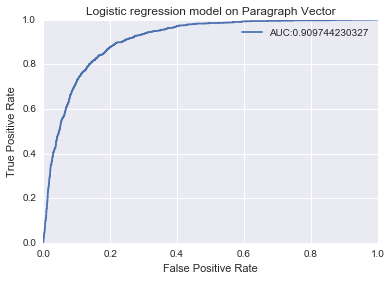

In [148]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
fpr, tpr, thresholds = metrics.roc_curve(
                            df['actual_label'].tolist(),
                            df['predicted_label_proba'].tolist(), 
                            pos_label=1
                        )
auc = metrics.auc(fpr, tpr)
rocdf = pd.DataFrame(np.transpose([fpr, tpr, thresholds]), columns = ['fpr','tpr','thresholds'])
rocdf.plot(x='fpr',y='tpr', label='AUC:{0}'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic regression model on Paragraph Vector')
plt.show()

From the ROC curve above, we observe that 20-dimensional doc2vec encoding of the newsgroups dataset achieves an accuracy of 0.91, which is comparable to the performance of a 634-dimensional tf-idf vector representation. By increasing the doc2vec size to 100, we get equal performance as the tf-idf representation (0.94).